In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpyro
numpyro.set_host_device_count(8)

In [3]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import jax
import jax.numpy as jnp
import jax.scipy.special as jss
import intensity_models
from intensity_models import pop_model, pop_cosmo_model
import lal
import lalsimulation as ls
import matplotlib.pyplot as plt
import numpy as np
from numpyro.infer import MCMC, NUTS
import os.path as op
import paths
import pandas as pd
import re
import scipy.stats as ss
import seaborn as sns
import time
from utils import jnp_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

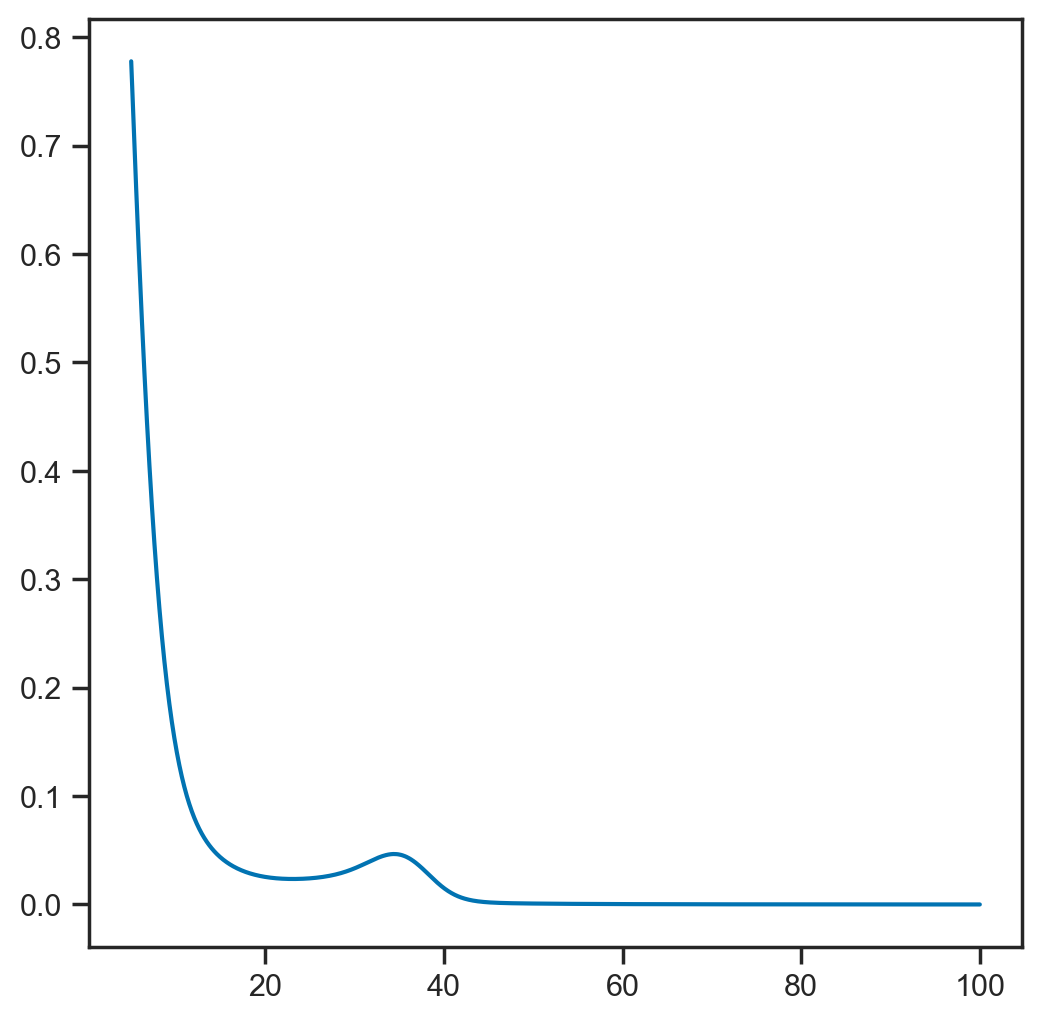

In [4]:
m = np.linspace(5, 100, 1024)
plt.plot(m, np.exp(weighting.default_log_dNdmdqdV(m, np.ones_like(m), np.zeros_like(m))))

In [5]:
trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: t

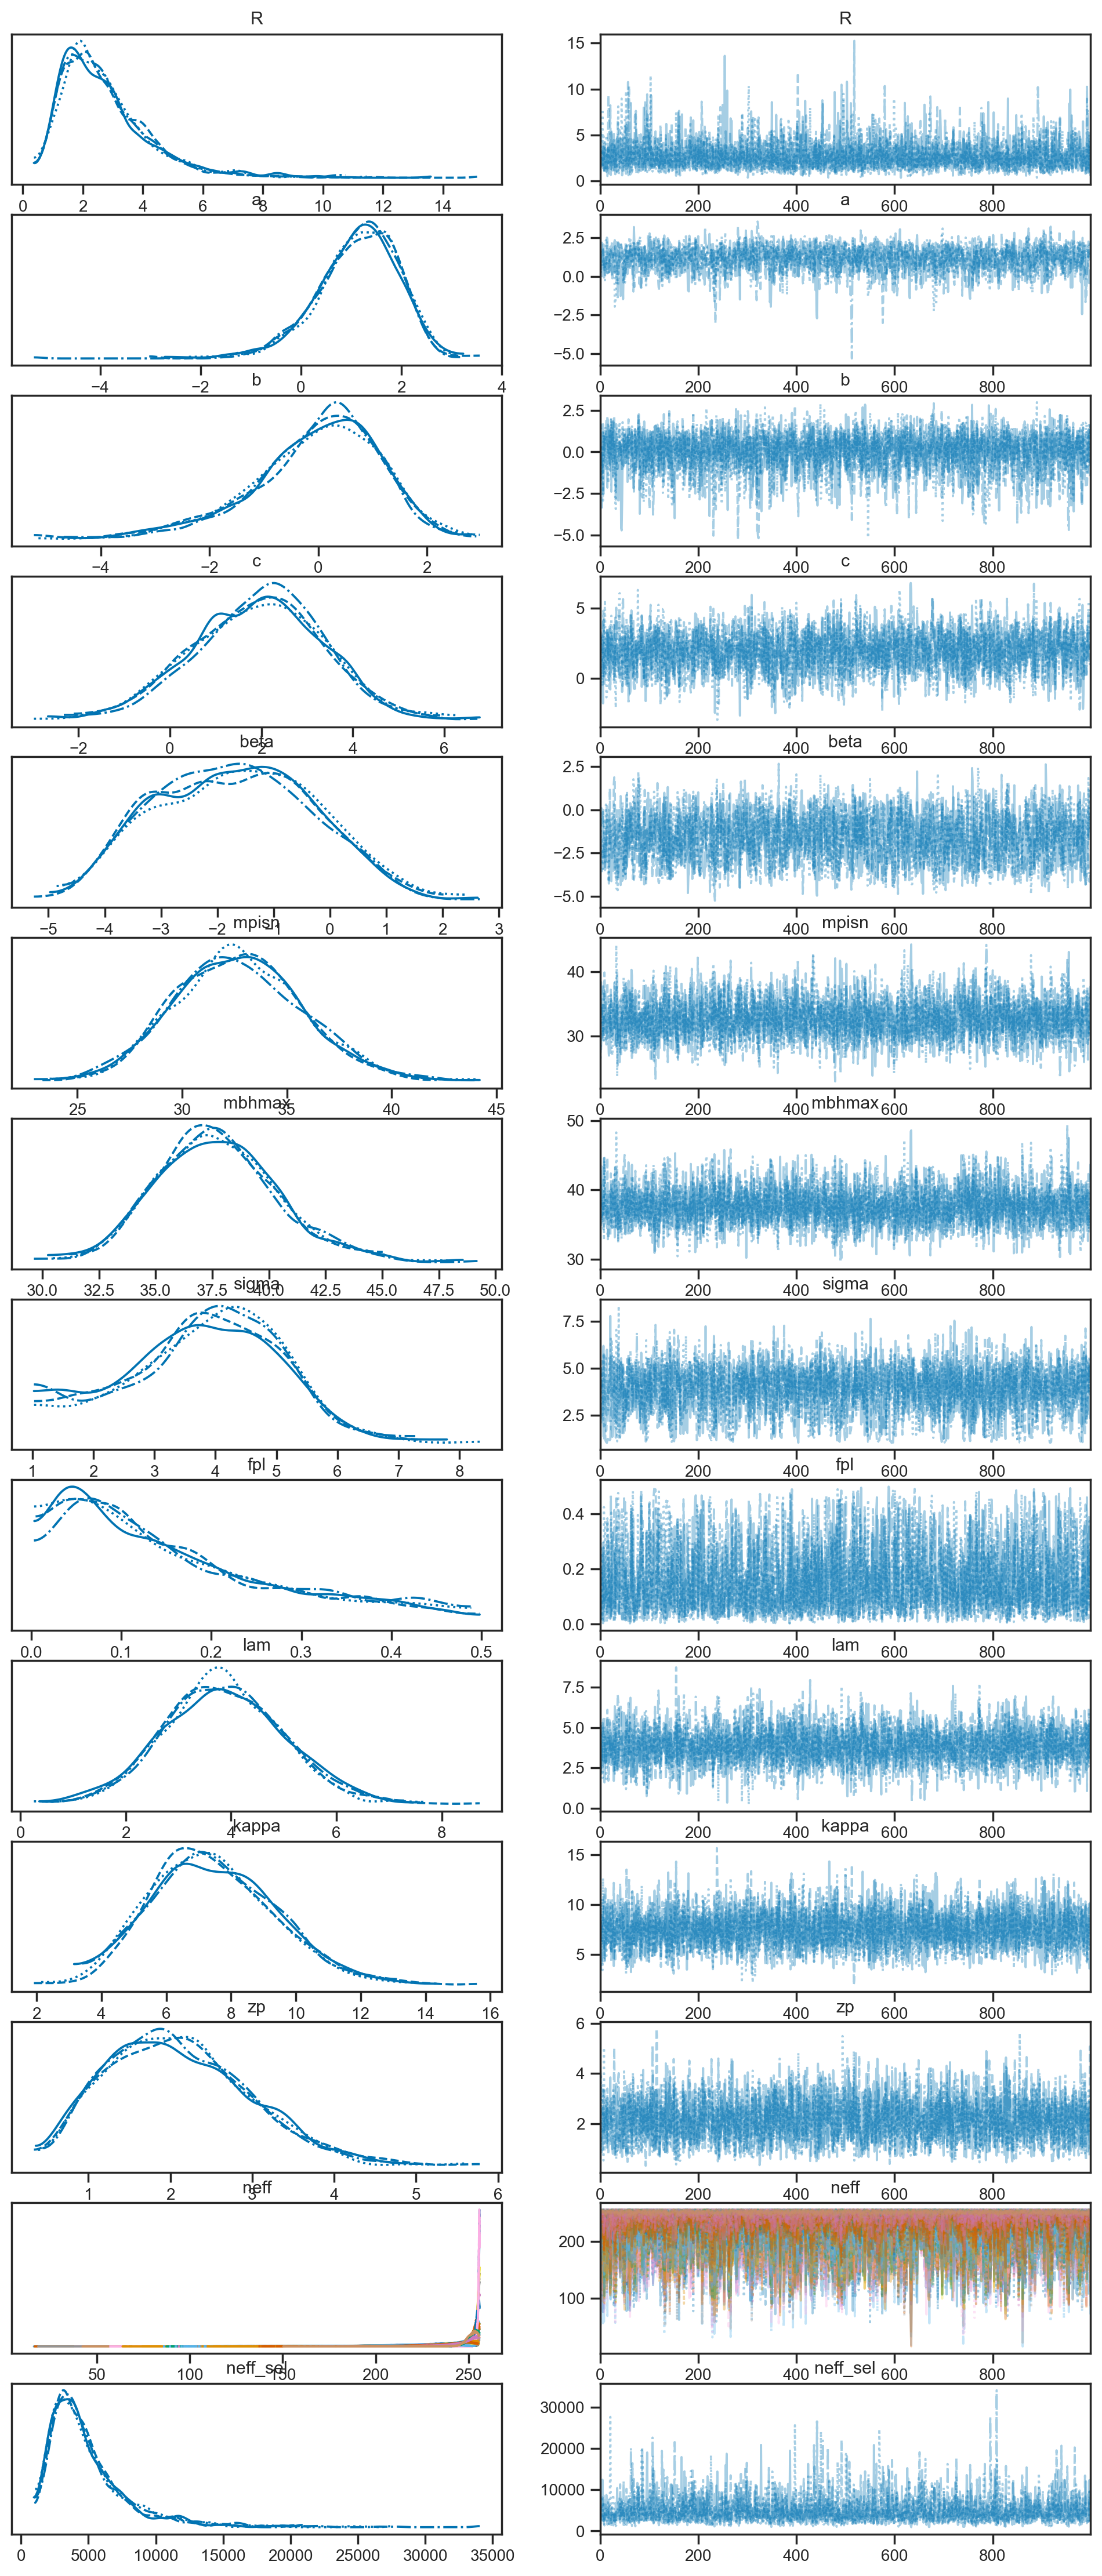

In [6]:
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'lam', 'kappa', 'zp', 'neff', 'neff_sel'])

In [7]:
inj = pd.read_hdf('../data/mock_injections.h5', key='true_parameters')

In [8]:
obs = pd.read_hdf('../data/mock_observations.h5', 'observations')
obs['m1_det'] = obs['m1']*(1 + obs['z'])
obs['dl'] = Planck18.luminosity_distance(obs['z'].to_numpy()).to(u.Gpc).value

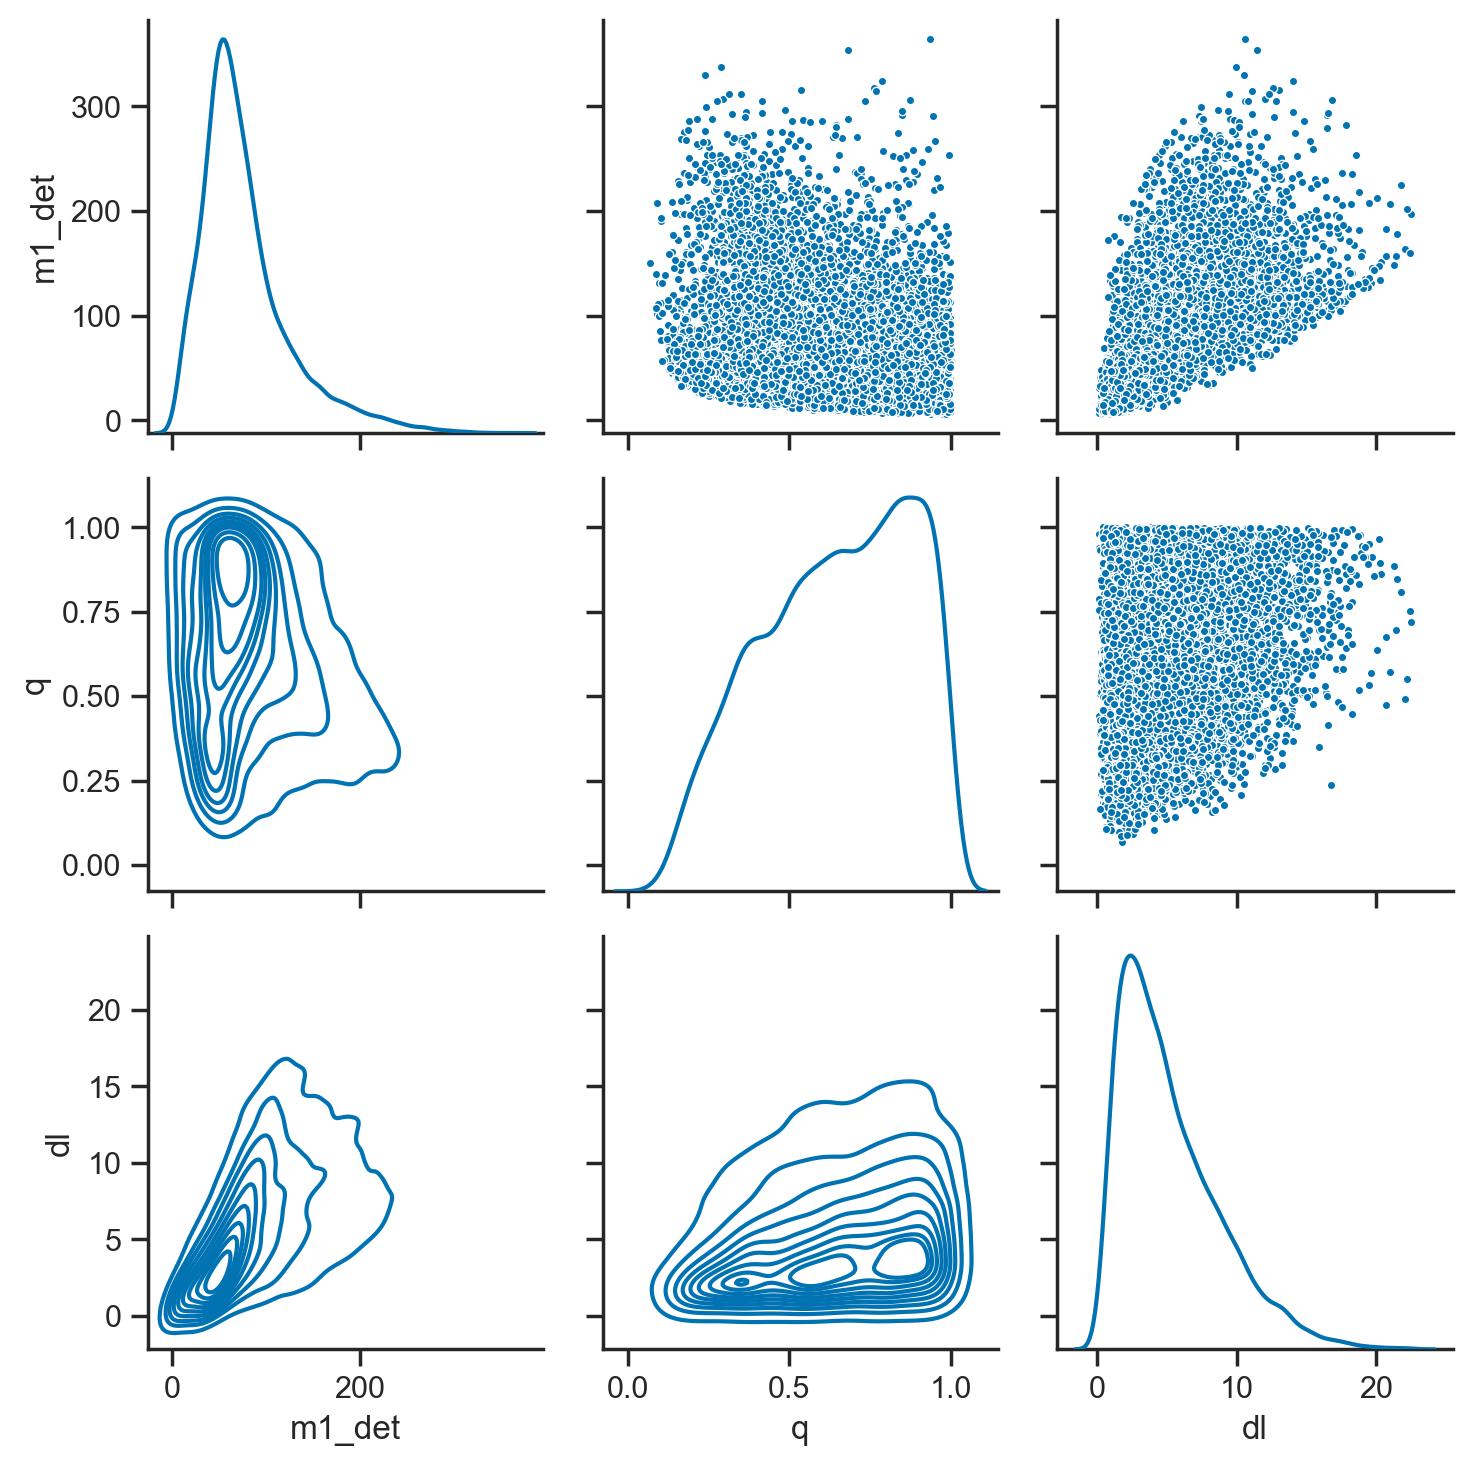

In [9]:
pg = sns.PairGrid(obs[['m1_det', 'q', 'dl']], diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')

<Axes: xlabel='dl', ylabel='m1_det'>

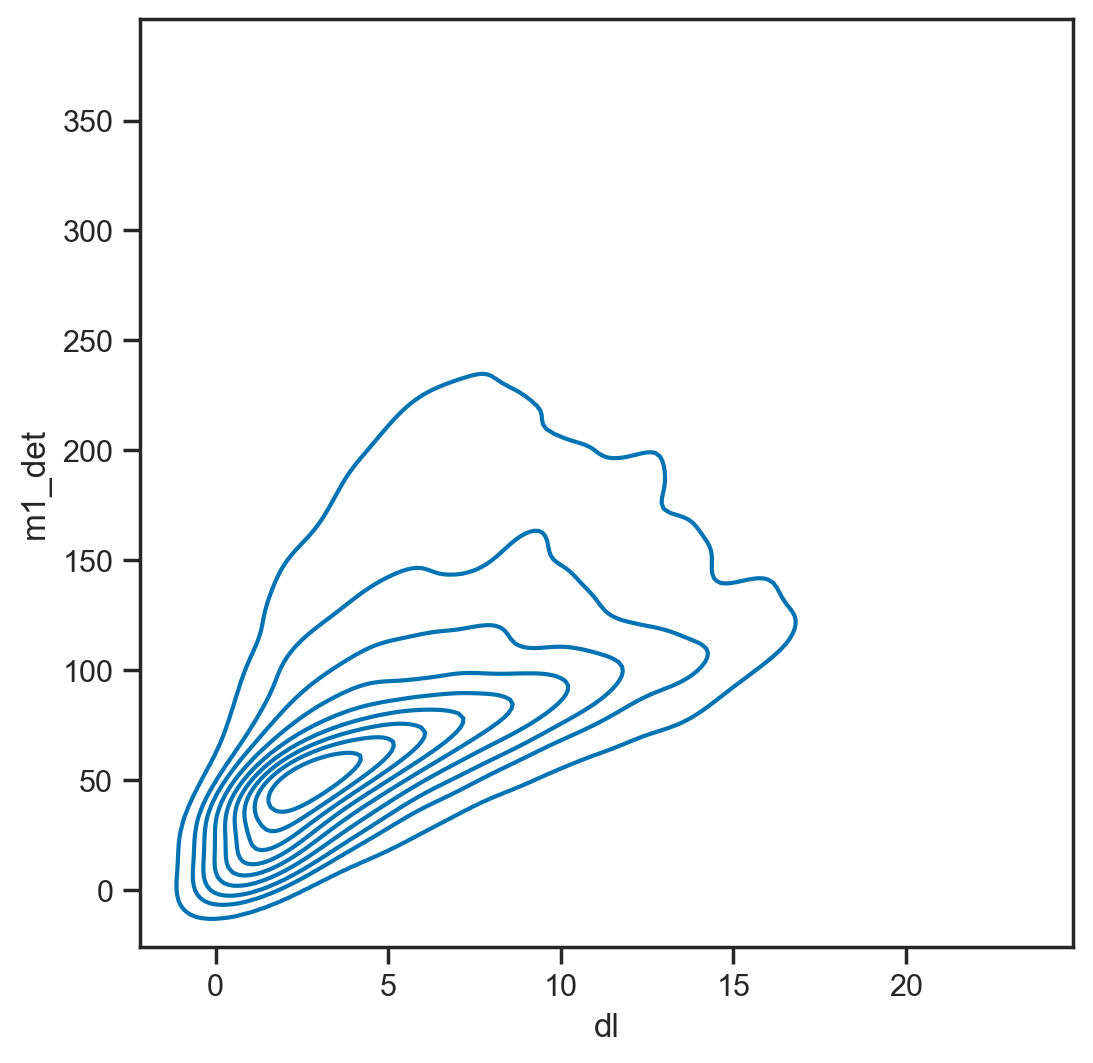

In [10]:
sns.kdeplot(y=obs['m1_det'], x=obs['dl'])

In [11]:
nex = weighting.default_parameters.R*np.sum(weighting.default_pop_wt(obs['m1'], obs['q'], obs['z'])/obs['pdraw_mqz'])/len(inj)
nex

455.2632176827747

In [12]:
n = np.random.poisson(nex)

In [13]:
samples = pd.read_hdf('../data/mock_year_samples.h5', key='samples')

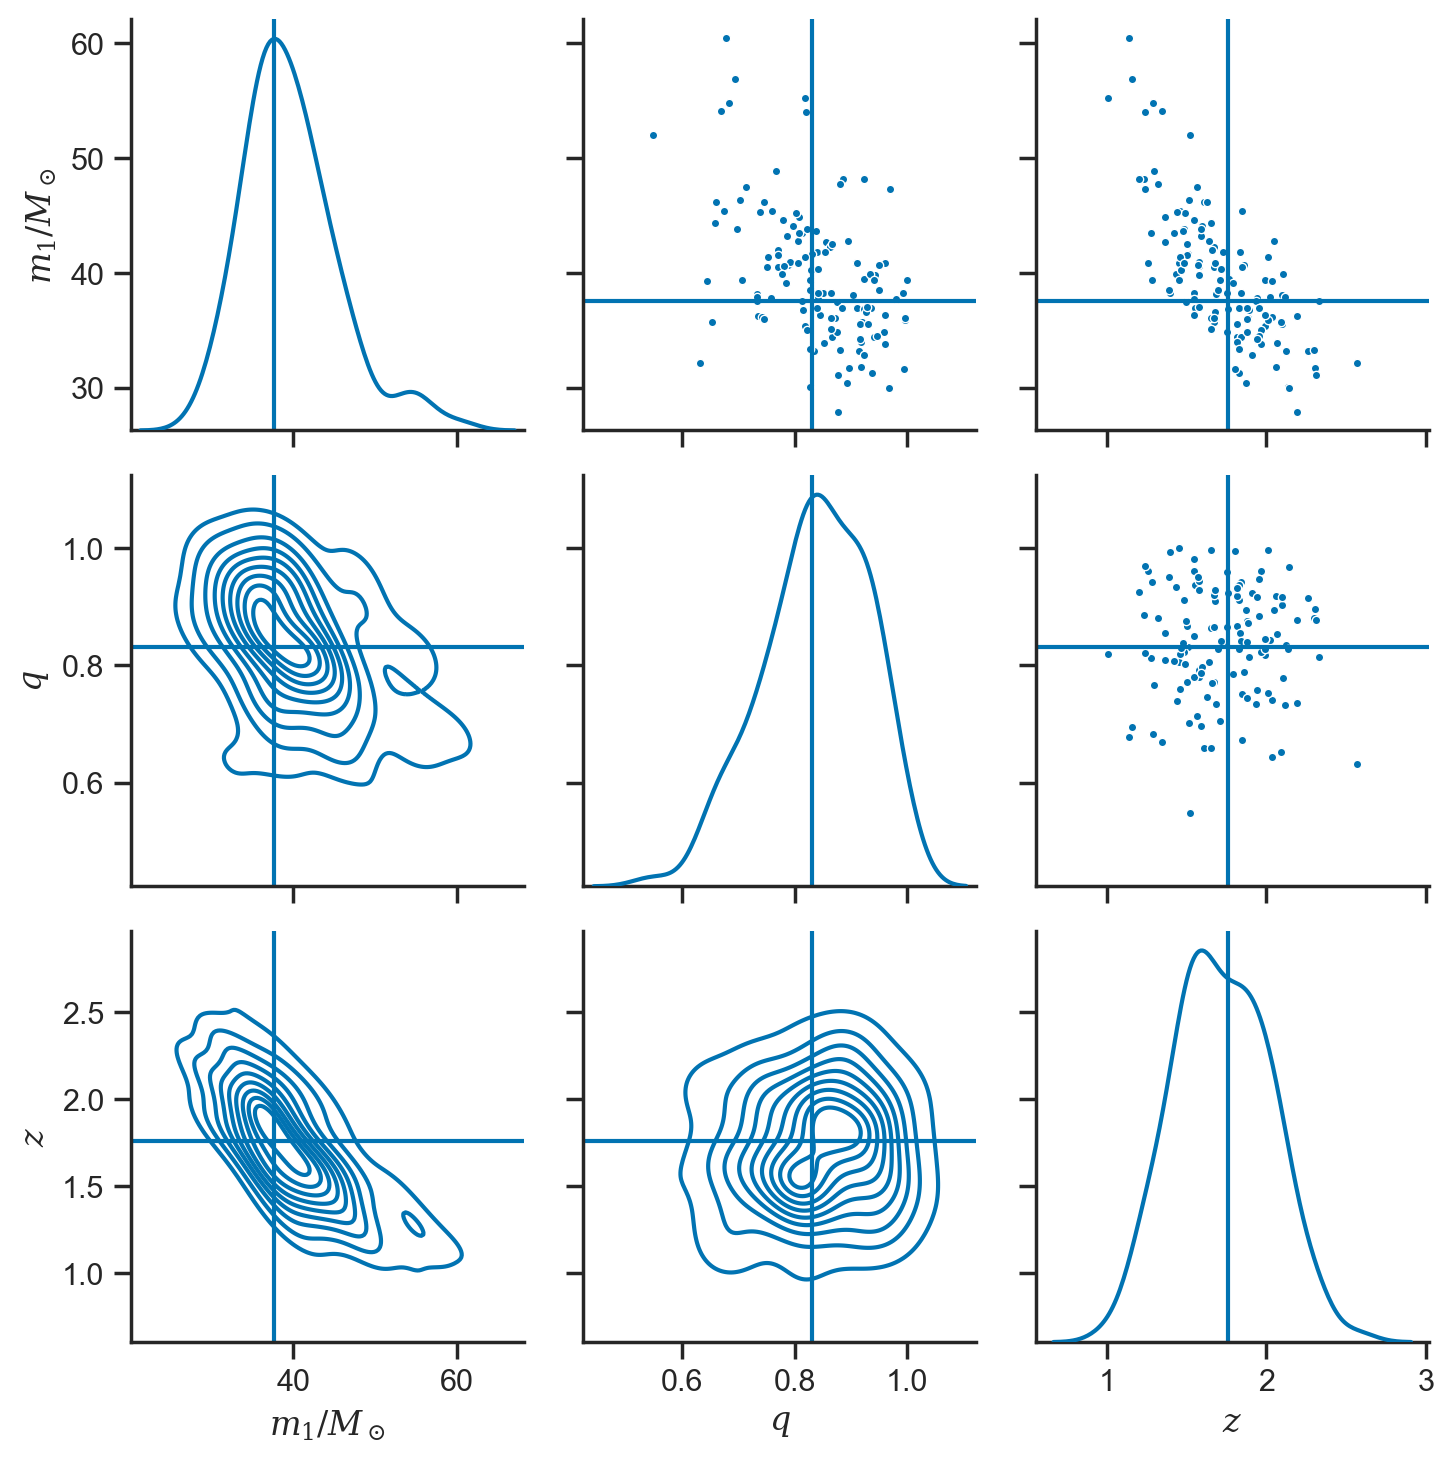

In [14]:
i = np.random.randint(len(samples['evt'].unique()))

truth_row=obs.iloc[i]
t = [truth_row['m1'], truth_row['q'], truth_row['z']]

s = samples[samples['evt'] == i]

pg = sns.PairGrid(pd.DataFrame({r'$m_1 / M_\odot$': s['m1'], r'$q$': s['q'], r'$z$': s['z']}), diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')
pg.map_lower(sns.kdeplot)

for i, tr in enumerate(t):
    for j, tc in enumerate(t):
        if i == j:
            pg.axes[i,j].axvline(tr)
        else:
            pg.axes[i,j].axvline(tc)
            pg.axes[i,j].axhline(tr)

In [15]:
g = samples.groupby('evt')
m = np.stack([s.to_numpy() for _, s in g['m1']], axis=0)
q = np.stack([s.to_numpy() for _, s in g['q']], axis=0)
z = np.stack([s.to_numpy() for _, s in g['z']], axis=0)
wt = np.stack([s.to_numpy() for _, s in g['wt']], axis=0)

In [18]:
m_true = np.array([obs['m1'].iloc[i] for i, _ in samples.groupby('evt')])
q_true = np.array([obs['q'].iloc[i] for i, _ in samples.groupby('evt')])
z_true = np.array([obs['z'].iloc[i] for i, _ in samples.groupby('evt')])

md_true = m_true + (1+z_true)
d_true = Planck18.luminosity_distance(z_true).to(u.Gpc).value

wt_true = np.ones_like(z_true)

In [19]:
use_true_params = True
nmcmc = 1000
nchain = 4

kernel = NUTS(intensity_models.pop_model, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
if use_true_params:
    mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), m_true.reshape((-1, 1)), q_true.reshape((-1,1)), z_true.reshape((-1,1)), wt_true.reshape((-1,1)), obs['m1'], obs['q'], obs['z'], obs['pdraw_mqz'], len(inj))
else:
    mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), m, q, z, wt, obs['m1'], obs['q'], obs['z'], obs['pdraw_mqz'], len(inj))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
trace = az.from_numpyro(mcmc)

/Users/wfarr/miniconda3/envs/BumpCosmology/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff_sel'}>,
        <Axe

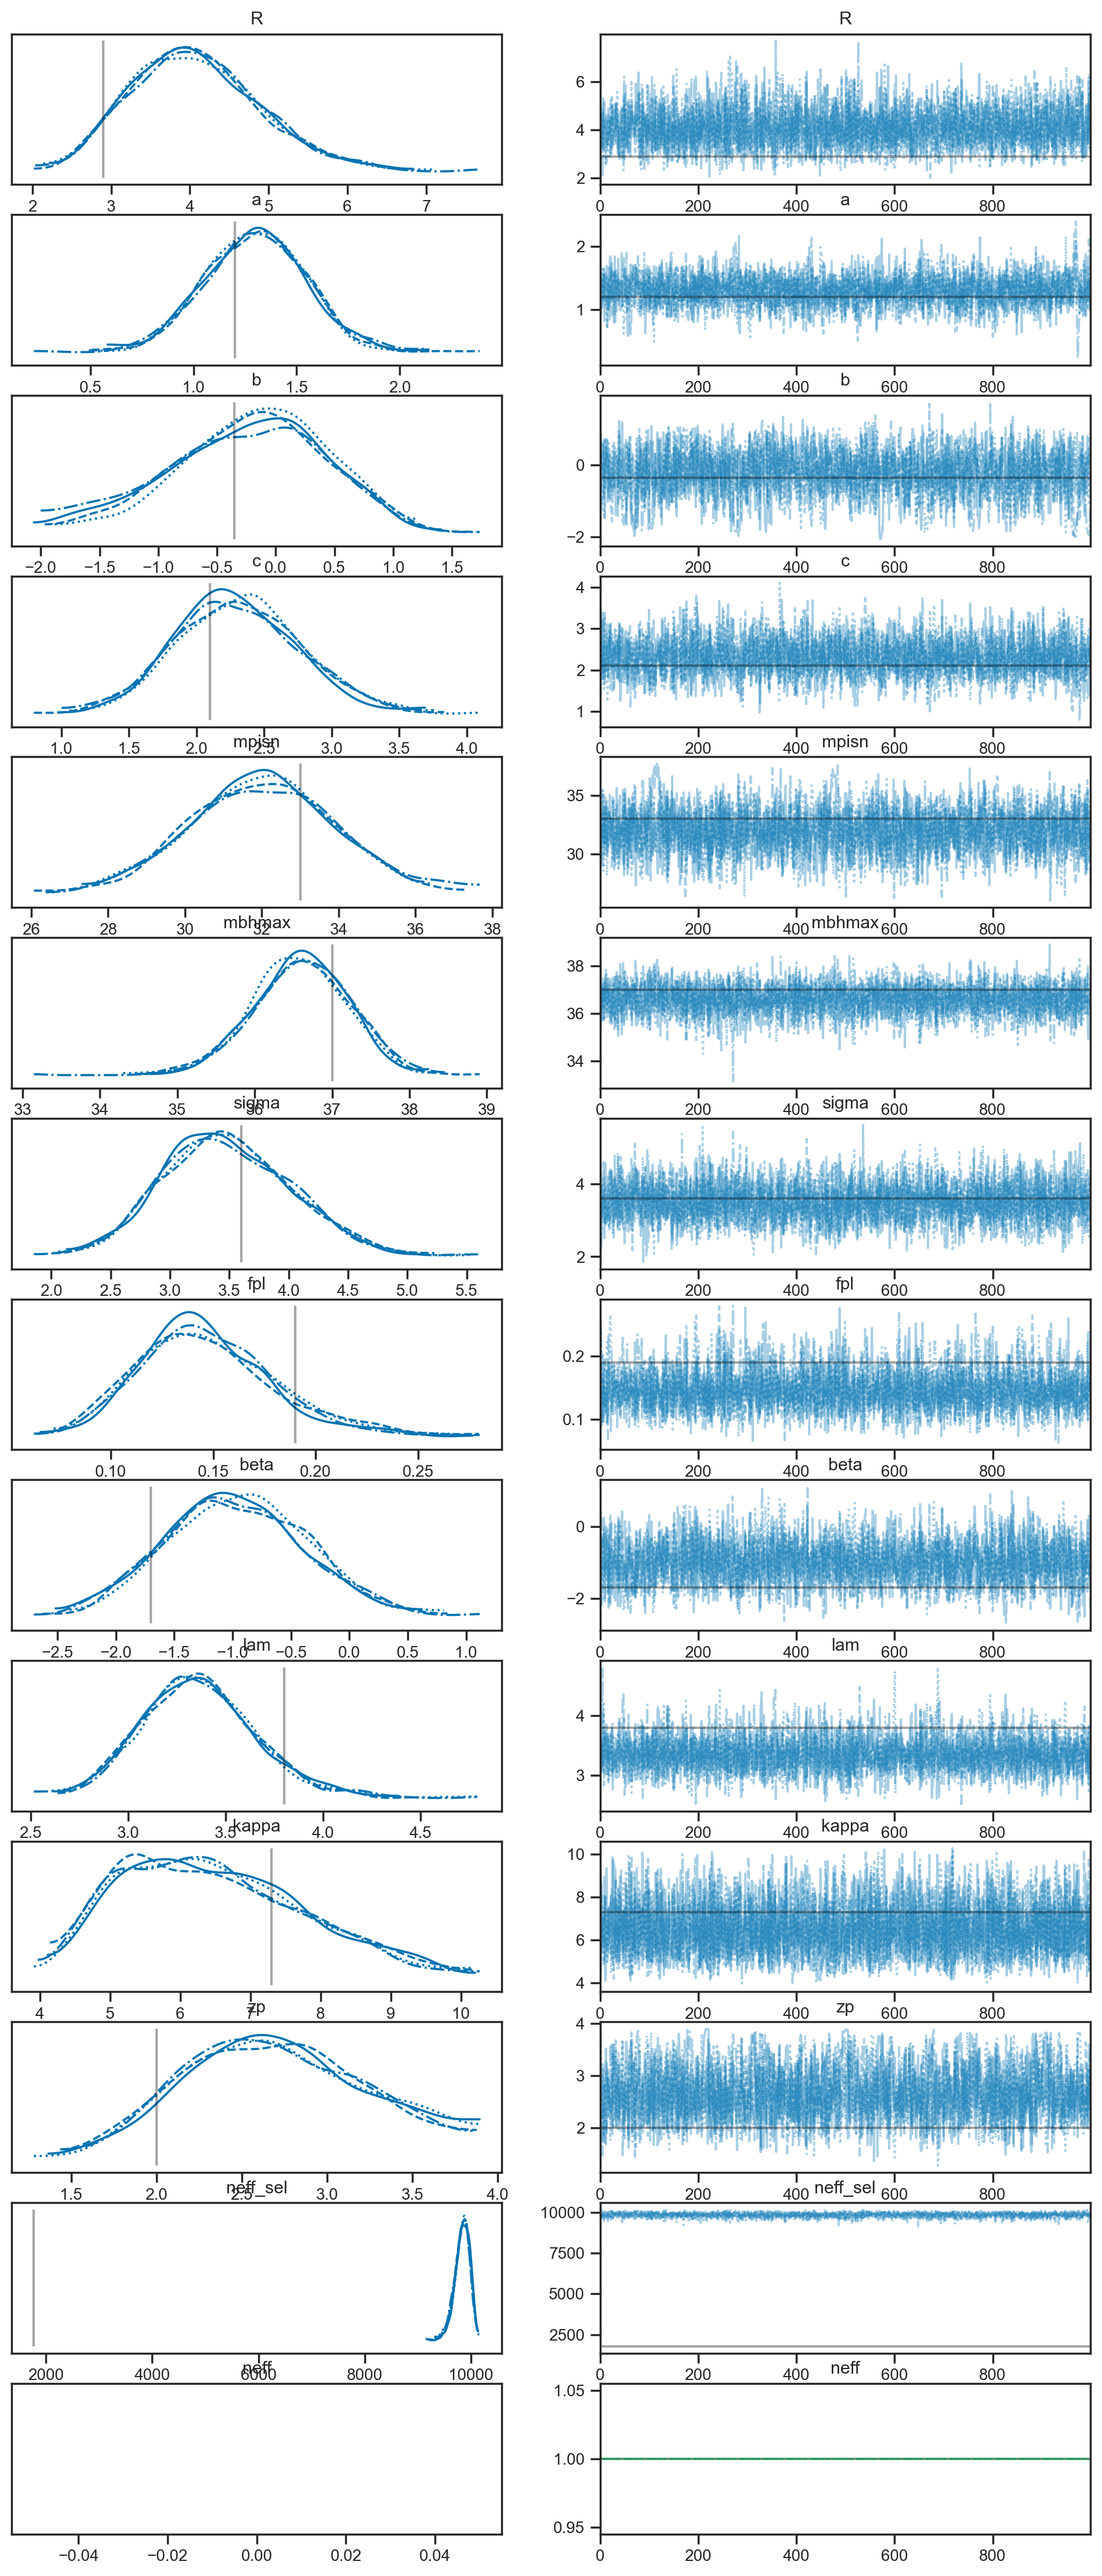

In [21]:
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'beta', 'lam', 'kappa', 'zp', 'neff_sel', 'neff'],
              lines=[(k, {}, weighting.default_parameters.__getattribute__(k)) for k in ['R', 'a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'beta', 'lam', 'kappa', 'zp']] + \
                    [('neff_sel', {}, 4*len(m_true))])

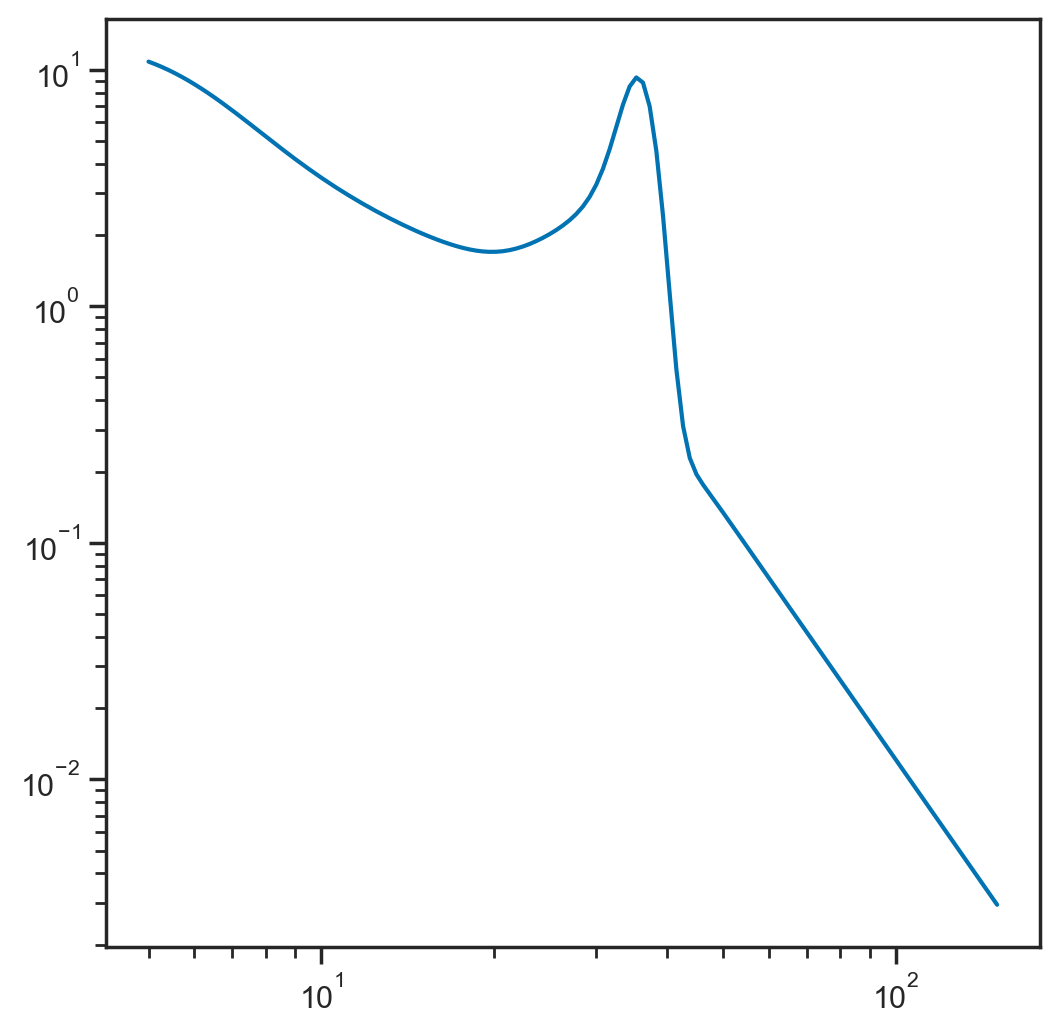

In [22]:
plt.plot(intensity_models.coords['m_grid'], trace.posterior.mdNdmdVdt_fixed_qz.sel(chain=0, draw=0))
plt.yscale('log')
plt.xscale('log')

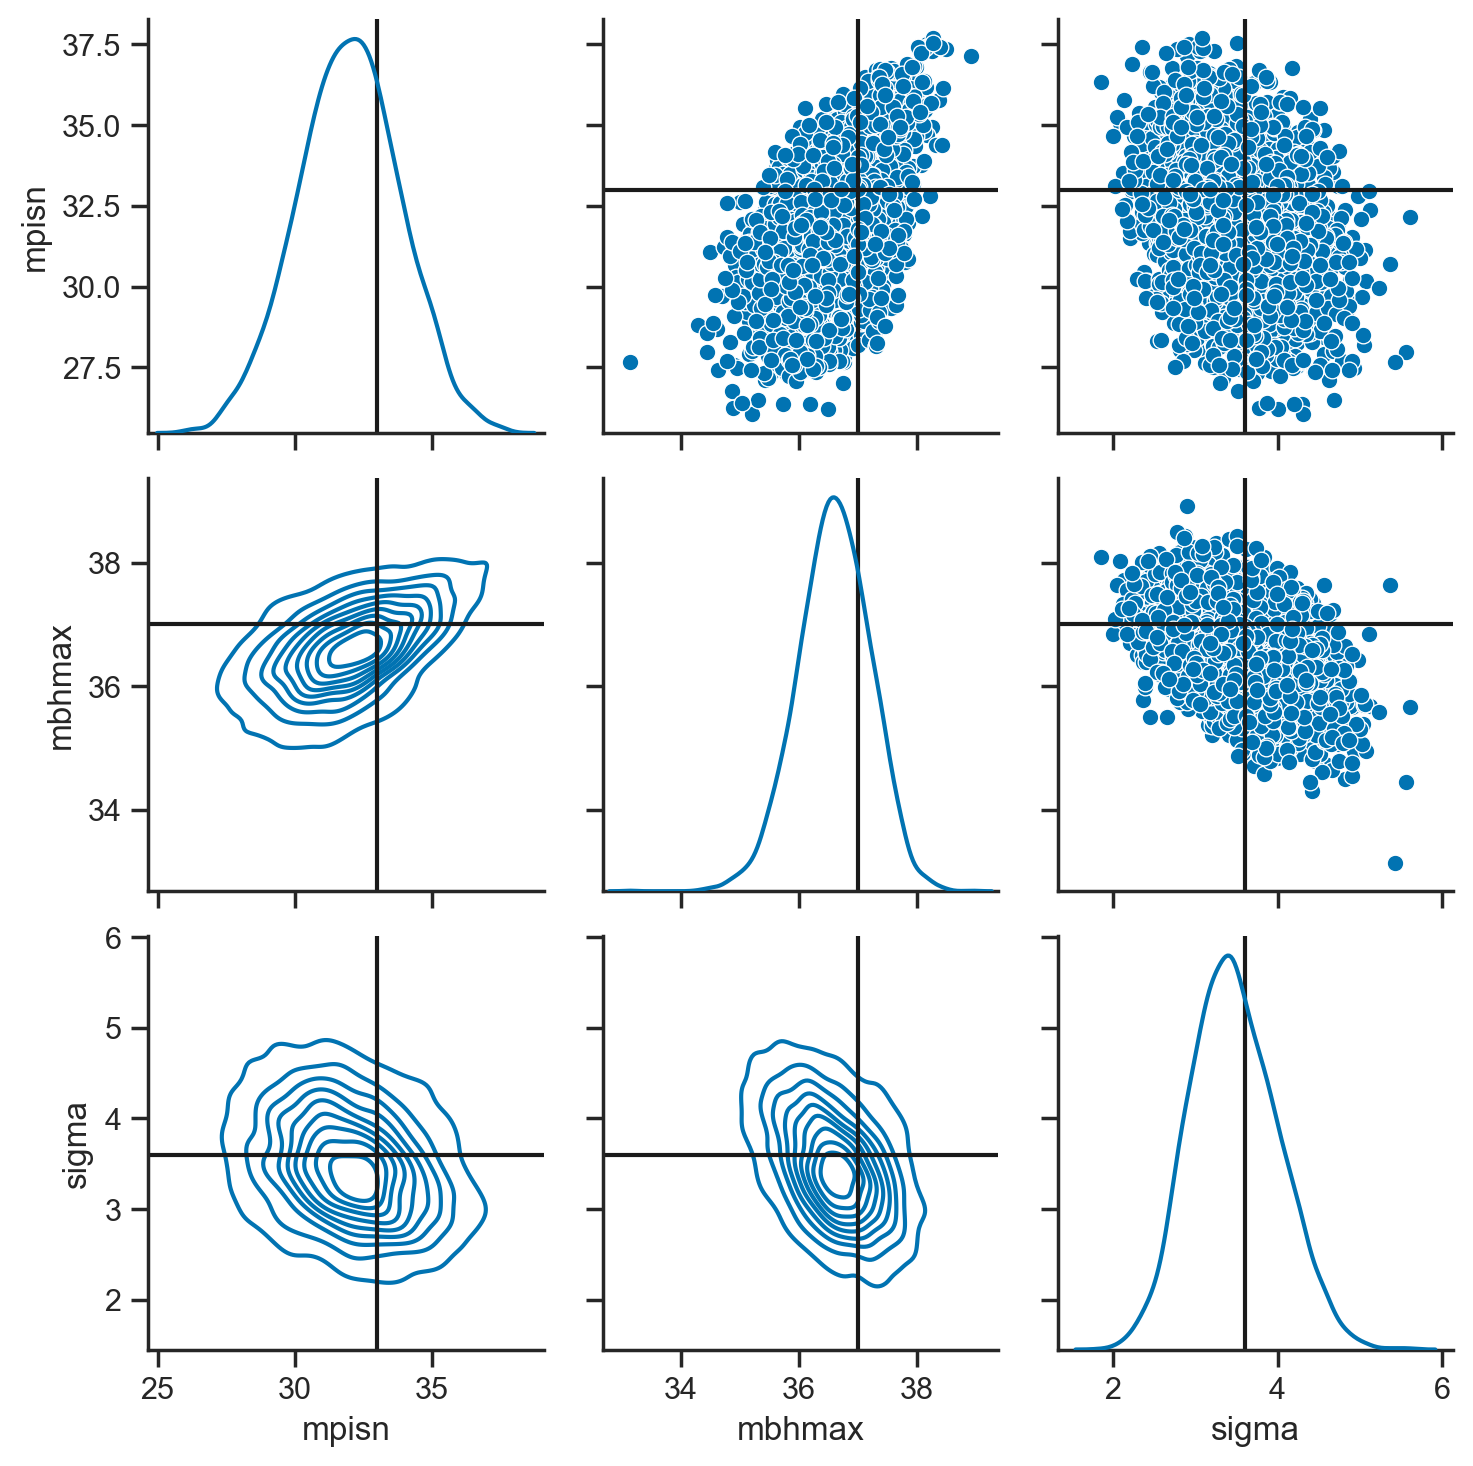

In [25]:
df = pd.DataFrame({k: trace.posterior[k].values.flatten() for k in ['mpisn', 'mbhmax', 'sigma']})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [weighting.default_parameters.__getattribute__(k) for k in ['mpisn', 'mbhmax', 'sigma']]
for i in range(3):
    for j in range(3):
        if i == j:
            pg.axes[i,j].axvline(t[i], color='k')
        else:
            pg.axes[i,j].axhline(t[i], color='k')
            pg.axes[i,j].axvline(t[j], color='k')